#### 5 year Forecasting With ResellerSales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '0' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast
...,...,...,...,...
60914,2014-05-01,Reseller,316.860,Southwest
60915,2014-05-01,Reseller,809.760,Southwest
60916,2014-05-01,Reseller,3274.800,Southwest
60917,2014-05-01,Reseller,97.182,Southwest


In [4]:
df.OrderDate.max() 

Timestamp('2014-05-01 00:00:00')

In [5]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [7]:
online_channel= df.loc[df['Region'] == 'Southwest',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
51,2011-05-31,Reseller,419.4589,Southwest
70,2011-05-31,Reseller,419.4589,Southwest
71,2011-05-31,Reseller,2146.9620,Southwest
72,2011-05-31,Reseller,356.8980,Southwest
73,2011-05-31,Reseller,874.7940,Southwest
...,...,...,...,...
60914,2014-05-01,Reseller,316.8600,Southwest
60915,2014-05-01,Reseller,809.7600,Southwest
60916,2014-05-01,Reseller,3274.8000,Southwest
60917,2014-05-01,Reseller,97.1820,Southwest


### Data Preprocessing

In [8]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [9]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-05-31,1.000564e+05
1,2011-07-01,2.991945e+05
2,2011-08-01,3.965098e+05
3,2011-08-31,1.495139e+05
4,2011-10-01,4.611494e+05
5,2011-10-31,4.876436e+05
6,2011-12-01,1.161828e+05
7,2012-01-01,5.018377e+05
8,2012-01-29,3.920309e+05
9,2012-02-29,1.301641e+05


### Indexing with Time Series Data

In [10]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-05-31', '2011-07-01', '2011-08-01', '2011-08-31',
               '2011-10-01', '2011-10-31', '2011-12-01', '2012-01-01',
               '2012-01-29', '2012-02-29', '2012-03-30', '2012-04-30',
               '2012-05-30', '2012-06-30', '2012-07-31', '2012-08-30',
               '2012-09-30', '2012-10-30', '2012-11-30', '2012-12-31',
               '2013-01-28', '2013-02-28', '2013-03-30', '2013-04-30',
               '2013-05-30', '2013-06-30', '2013-07-31', '2013-08-30',
               '2013-09-30', '2013-10-30', '2013-11-30', '2013-12-31',
               '2014-01-29', '2014-03-01', '2014-03-31', '2014-05-01'],
              dtype='datetime64[ns]', name='OrderDate', freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [11]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [12]:
y['2014':]

OrderDate
2014-01-01    458166.29520
2014-02-01    573158.41355
2014-03-01    573158.41355
2014-04-01    596834.78410
2014-05-01    596834.78410
Freq: MS, Name: Total_Sales, dtype: float64

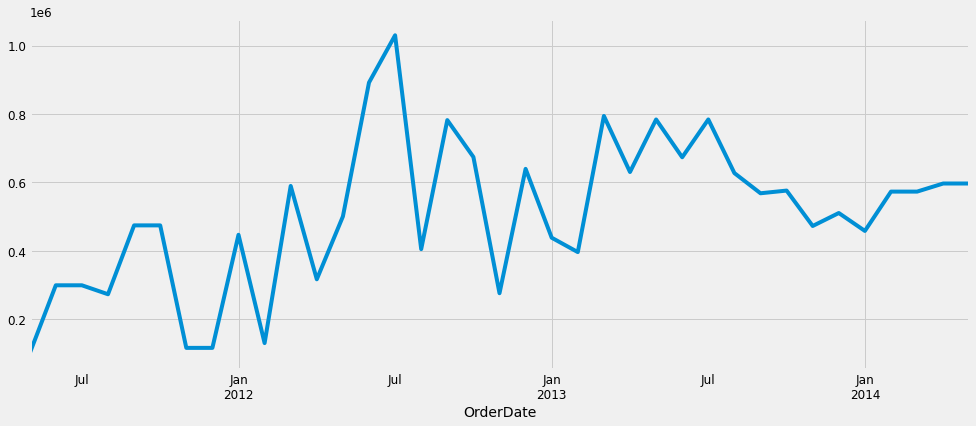

In [13]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [15]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1057.4701444468622
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:695.986760331903
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:675.5088788760188
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:328.7508176205629
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:704.5298640404296
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:672.4871666015308
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:354.7447025394254
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:330.73211763647134
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1012.7899165689538
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:663.8196555322443
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:641.5400062866203
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:301.05858065362173
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:720.5803803575245
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:664.3514543074723
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:358.3452446887569
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:302.98771780542296
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:968.9431295897529
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:633.3813812913221
ARIMA(

 ### Fitting an ARIMA Time Series Model

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3451    116.887     -0.003      0.998    -229.439     228.748
ma.L1          0.3522    126.059      0.003      0.998    -246.719     247.424
ar.S.L12       0.3601      4.048      0.089      0.929      -7.574       8.294
ma.S.L12      -1.1887      2.607     -0.456      0.648      -6.298       3.921
sigma2      5.489e+10   3.25e-08   1.69e+18      0.000    5.49e+10    5.49e+10


### Validating forecasts

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2011-06-01'), end=pd.to_datetime('2014-05-31 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()



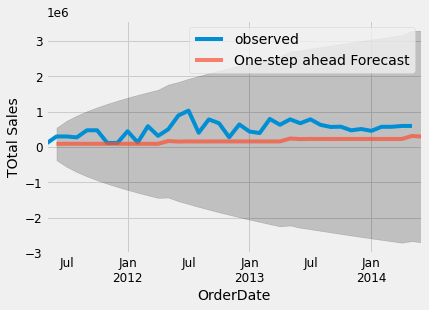

In [19]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()

plt.show()

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 101070660056.98


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 317916.12


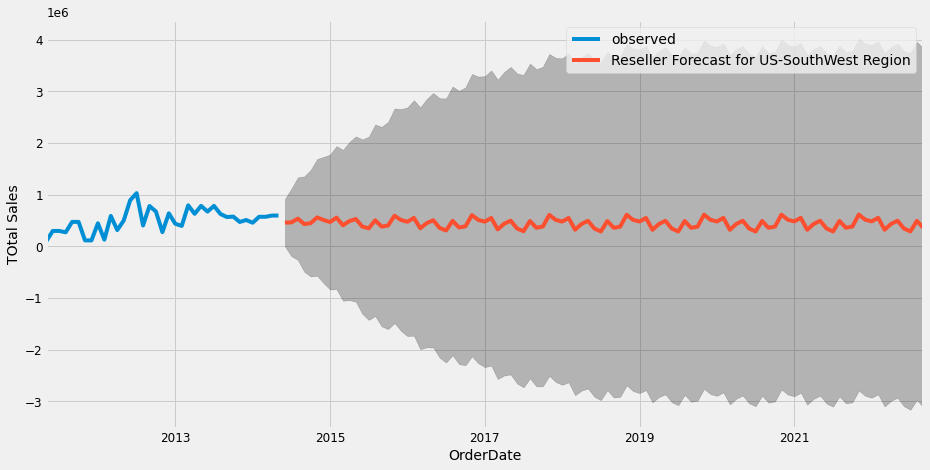

In [23]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Reseller Forecast for US-SouthWest Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()
plt.show()